In [ ]:
#!conda install dask[array]

### Что такое Dask
`Dask` -- библиотека для параллельных и распределенных численных вычислений. Применяется, если:
1. Данные не влезают в память. `Dask` позволяет организовать конвейерное выполнение алгоритма, разделяя данные на чанки.
2. Алгоритм выполняется долго и может быть параллелизован и запущен на распределенной системе (кластере, сети, суперкомпьютере). Тогда `Dask` осуществляет не только конвейеризацию, но и оркестрирование процесса вычислений.

Преимущества `Dask`:
1. Высокая степень совместимости с массивами `numpy` и фреймами `pandas`.
2. Высокая скорость работы, низкие накладные расхода на оркестрацию и конвейеризацию.
3. Возможность работы кода как на локальной машине, так и на кластере.
4. Позволяет параллелизовать не только код, использующий `numpy` и `pandas`, но и код с произвольными объектами.

Основная идея `Dask` -- ленивые конвейеризованные вычисления.
![dask](Dask1.jpeg "dask")

### Инструментарий Dask
В `Dask` существует три уровня инструментов:
1. Низкоуровневые для обертки произвольных функций.
2. Высокоуровневые для обертки массивов, фреймов и других коллекций.
3. Инструменты оркестрации, распределения задач
![dask2](Dask2.png "dask 2")

In [1]:
import dask
import dask.array as da
import dask.bag as db

import cupy as cp
import numpy as np
print("Dask   version: ", dask.__version__)

Dask   version:  2021.10.0


### Низкоуровневые инструменты: delayed, future
Чтобы понять, что такое `delayed` и `future`, проведем такую аналогию:
1. `delayed` -- это генераторы, то есть объекты, хранящие путь вычисления результата и лениво вычисляющие его по требованию. Чаще используются в локальных вычислениях.
2. `future` -- это сопрограммы, то есть объекты, 
вычисляющие результат асинхронно и хранящие информацию о своем состоянии, которую они могут выдать по запросу. Чаще используются в распределенных вычислениях.

### Общая концепция вычислений на примере `delayed`
`Dask` первым делом строит анализирует вычисления и строит граф программы, производительность которого и оптимизирует.
Как правильно применять `delayed` можно посмотреть [в официальной документации](https://docs.dask.org/en/latest/delayed-best-practices.html).

Для визуализации понадобятся библиотеки `graphviz` и `python-graphviz`.

In [9]:
#!conda install -c conda-forge python-graphviz graphviz

^C


In [2]:
import time
def is_palindrome(s):
    time.sleep(0.1)
    return s.upper() == s.upper()[::-1]

string_list = ['redivider', 'deified', 'civic', 'radar', 'level',
               'rotor', 'kayak', 'reviver', 'racecar', 'madam', 'refer',
               'Being',  'man', 'not', 'without', 'frequent', 'consciousness',
               'that', 'there', 'was', 'some', 'charm', 'this', 'life', 'stood',
               'still', 'after', 'looking', 'sky', 'useful', 'instrument',
               'regarded', 'appreciative', 'spirit', 'work', 'art',
               'superlatively', 'beautiful', 'moment', 'seemed',
               'impressed', 'with', 'speaking', 'loneliness', 'scene',
               'rather', 'complete', 'abstraction', 'from', 'compass',
               'sights', 'sounds', 'man', 'Human', 'shapes', 'interferences',
               'troubles', 'joys', 'were', 'they', 'were', 'there',
               'seemed', 'shaded', 'hemisphere', 'globe', 'sentient', 'being',
               'save', 'himself']

In [4]:
%%time
palindromes_py = [is_palindrome(s) for s in string_list]

Wall time: 7.65 s


In [16]:
%%time
res = []
for x in string_list:
    #x = dask.delayed(lambda x: x * 2)(x)
    _r = dask.delayed(is_palindrome)(x)
    res.append(_r)

Wall time: 5 ms


In [10]:
res[:4]

[Delayed('is_palindrome-101bdb0b-f3a8-44f9-b638-a1ee73c889a6'),
 Delayed('is_palindrome-2a2e8cf1-2602-4e7b-9a31-cc92feeeed5d'),
 Delayed('is_palindrome-3517284f-bf0e-4b87-a6eb-cb0a13f53ed2'),
 Delayed('is_palindrome-7744fc3f-0f11-4553-8afa-a71ab4c01168')]

In [17]:
dmean = dask.delayed(np.sum)(res)

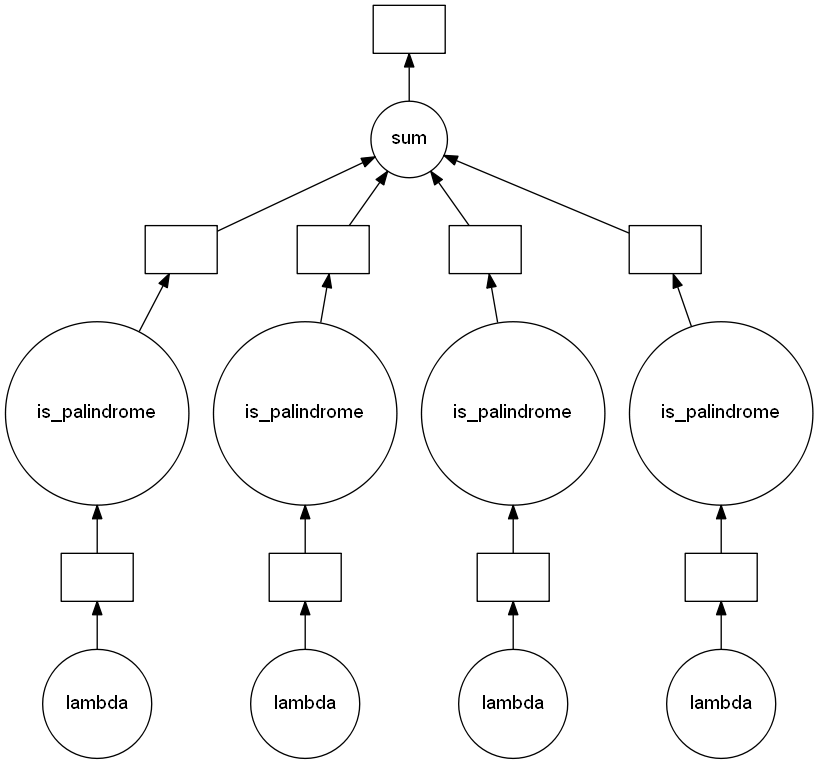

In [15]:
dmean.visualize()

In [23]:
%time dmean.compute()

Wall time: 987 ms


11

In [19]:
%time dask.compute(dmean)

Wall time: 984 ms


(11,)

### Высокоуровневые инструменты: `dask.array`, `dask.dataframe`, `dask.bag`
Рассмотрим пример применения инструмента [`dask.bag`](https://docs.dask.org/en/latest/bag.html) для параллелизации вычислений коллекций произвольных объектов (например, строк). Напишем плохую, медленную функцию и сравним с последовательным вычислением через `list comprehensions` и параллельным через `dask.delayed`, `joblib` и `loky`.

### Dask.bag
Параллельная обработка коллекций (файлов, строк, произвольных объектов). [Смотреть тут](https://docs.dask.org/en/latest/bag.html).
Возьмем простую функцию

Посмотрим, какова производительность кода для разных вариантов вычисления функции

In [24]:
%%time
palindromes_d = [dask.delayed(is_palindrome)(s) for s in string_list]
palindromes_dc = np.sum(dask.compute(*palindromes_d))

Wall time: 999 ms


In [26]:
from joblib import Parallel, delayed
%time palindromes_joblib = Parallel(n_jobs=-1, backend='loky')(delayed(is_palindrome)(s) for s in string_list)

Wall time: 994 ms


In [36]:
%%time
bag = db.from_sequence(string_list, npartitions=1).map(is_palindrome)
res = bag.compute(sheduler='processes')

Wall time: 8.48 s


In [35]:
bag

dask.bag<is_palindrome, npartitions=2>

In [30]:
%%time
bag = db.from_sequence(string_list).map(is_palindrome)
res = bag.compute(sheduler='processes')

Wall time: 2.21 s


### Dask.array
Параллельная обработка массивов `numpy` и `cupy`. Обеспечивается классом `dask.array`. `Dask.array` -- это массив, разделенный на чанки. Чтобы вычисления были быстрыми, чанков должно быть относительно мало. Иначе создается очень много объектов `dask.delayed`, что уменьшает скорость выполнения программы.

![array](dask-array.svg "array")

In [108]:
%%time
a = np.random.uniform(0, 1, size=(10000, 1000))
data = da.tile(a, (20,20))
data

Wall time: 202 ms


dask.array<concatenate, shape=(200000, 20000), dtype=float64, chunksize=(10000, 1000), chunktype=numpy.ndarray>

In [59]:
%%time
s = 0
for i in range(20*20):
    s += np.sum(a)
s

Wall time: 341 ms


200040951.955808

In [58]:
da.diag(data)

dask.array<diag, shape=(20000,), dtype=float64, chunksize=(1000,), chunktype=numpy.ndarray>

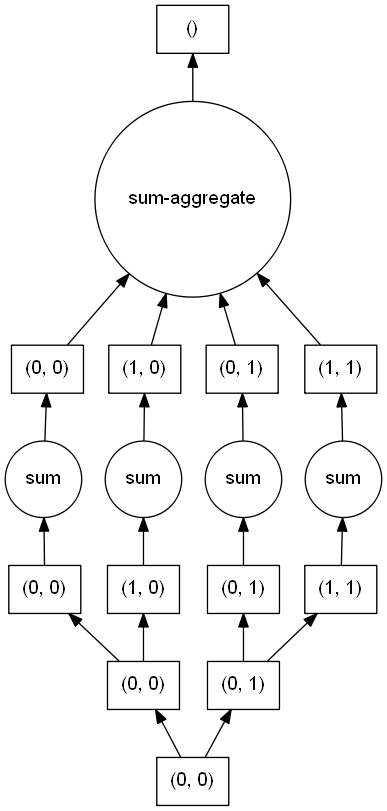

In [75]:
data.sum().visualize()

In [109]:
%time data.sum().compute()

Wall time: 3.54 s


2000229938.4149346

In [67]:
def compute_block_sum(block):
    return np.array([np.sum(block)])[:, None]

In [107]:
%time res = data.map_blocks(np.sum, drop_axis=(0,1))

Wall time: 998 µs


In [65]:
%time data.map_blocks(np.sum).compute()

IndexError: tuple index out of range

Wall time: 144 ms


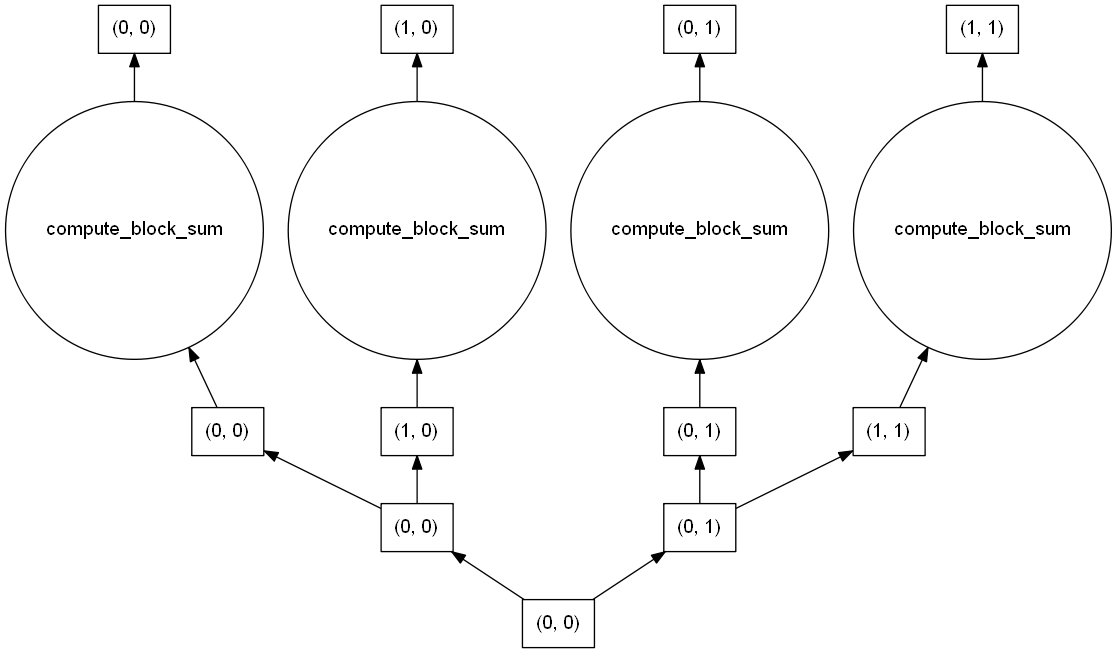

In [76]:
%time data.map_blocks(compute_block_sum, chunks=(1,1)).visualize()

In [114]:
%time res = data.map_blocks(compute_block_sum, chunks=(1,1)).compute()

Wall time: 1.14 s


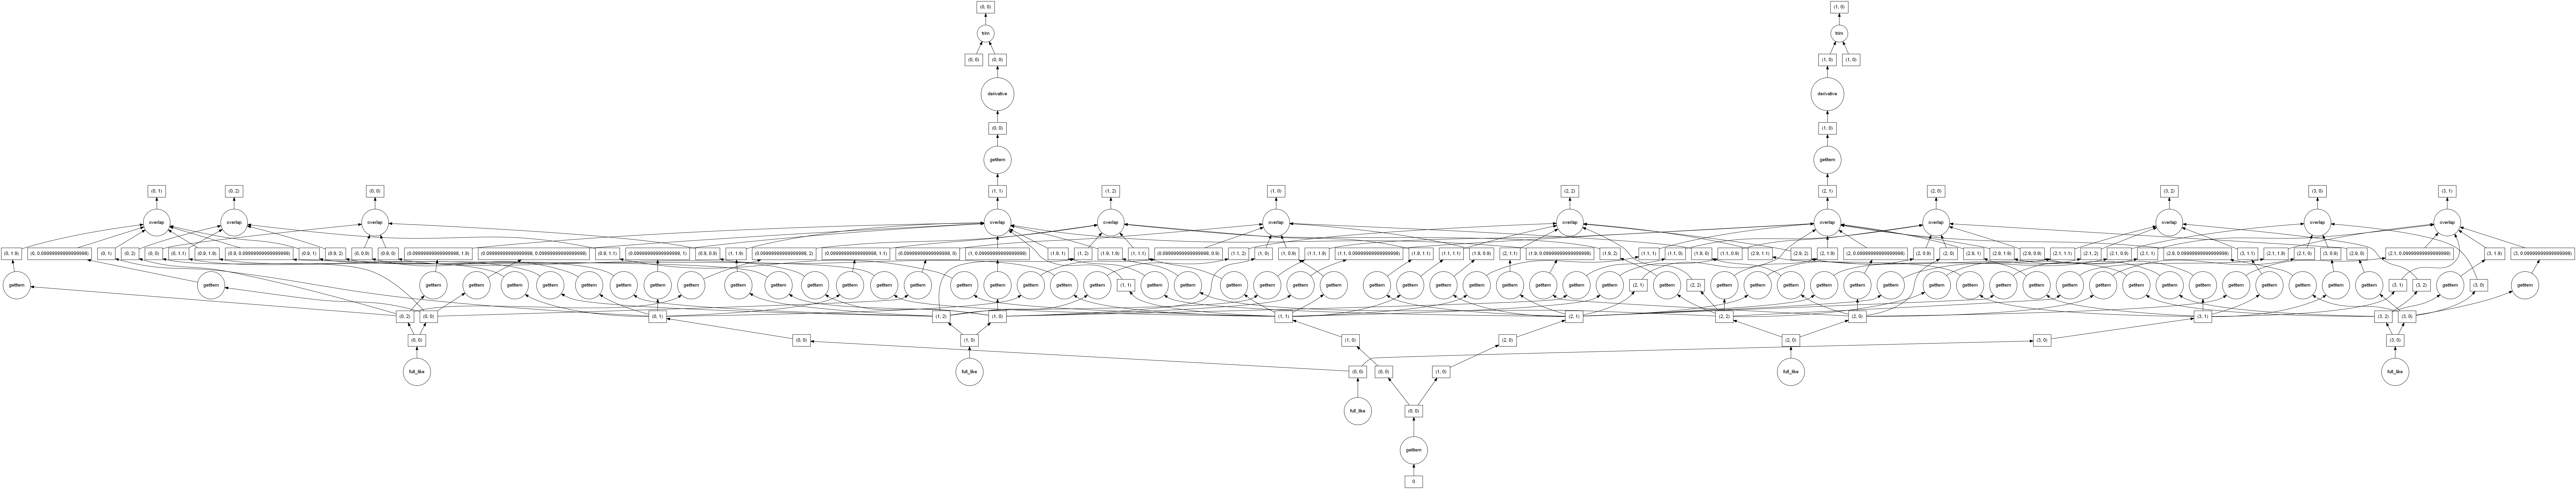

In [102]:
def derivative(x):
    return x - np.roll(x, 1)

data.map_overlap(derivative, depth=1, boundary=0).visualize()

### Dask Dashboard
Также `dask` предоставляет мониторинговый интерфейс, на котором можно следить за загрузкой системы и процессом вычислений.

In [103]:
from dask.distributed import Client, LocalCluster

cluster = LocalCluster()
client = Client(cluster)

In [111]:
client.close()